## Extension usage and development
This is a notebook for showcasing the usage and development of C/C++ extensions. As an example a plasma oscillation is simulated with and without absorbing boundaries. 

## Install extension

The extension (absorbing_boundaries.cpp) is compiled seperately from the pipic library according to the instructions below.

In [166]:
# copy files to local development environment
!cp ../../src/primitives.h . 
!cp ../../src/interfaces.h . 
!cp ../../src/services.h .
!cp ../../src/CMakeLists.txt .

In CMakeLists.txt change
```
set(pipic 
    pipic.cpp)
pybind11_add_module(_pipic${pipic})
```

to the name of the extension (here simply extension) as

```
set(extension 
    extension.cpp)
pybind11_add_module(extension${extension})
```

In [167]:
# or run this cell to exchange pipic to extension in CMakeLists.txt
!sed -i 's/\_pipic/extension/g' CMakeLists.txt
!sed -i 's/pipic/extension/g' CMakeLists.txt




If fftw is not installed, also delete the lines in CMakeLists.txt

```
find_package(PkgConfig REQUIRED)
pkg_search_module(FFTW REQUIRED fftw3 IMPORTED_TARGET)
include_directories(PkgConfig::FFTW)
link_libraries     (PkgConfig::FFTW)
```
as well as
```
#include <fftw3.h>
```
from primitives.h.

In [168]:
# download pybind11
!git clone https://github.com/pybind/pybind11

fatal: destination path 'pybind11' already exists and is not an empty directory.


In [169]:
# compile the extension
!cmake .
!make

-- pybind11 v3.0.2 
Using compatibility mode for Python, set PYBIND11_FINDPYTHON to NEW/OLD to silence this message
-- Configuring done
-- Generating done
-- Build files have been written to: /home/frida/Desktop/pipic/tutorials/extensions


Consolidate compiler generated dependencies of target extension
[ 50%] Building CXX object CMakeFiles/extension.dir/extension.cpp.o
[100%] Linking CXX shared module extension.cpython-312-x86_64-linux-gnu.so
[100%] Built target extension


## Set up simulation for plasma oscillation 

In [170]:
import pipic
from pipic import consts, types
import numpy as np
from numba import cfunc, carray
import extension
import matplotlib.pyplot as plt

In [171]:
# simulation variables 
temperature = 1e-6 * consts.electron_mass * consts.light_velocity**2
density = 1e18
debye_length = np.sqrt(temperature / (4 * np.pi * density * consts.electron_charge**2))
plasma_period = np.sqrt(np.pi * consts.electron_mass / (density * consts.electron_charge**2))
l = 128 * debye_length
xmin, xmax = -l / 2, l / 2
ymin, ymax = -1 , 1
zmin, zmax = -1,  1
field_amplitude = 0.01 * 4 * np.pi * (xmax - xmin) * consts.electron_charge * density
nz, ny, nx = 1, 1, 128
timestep = plasma_period / 64

dmin = - l/4
dmax = + l/4


In [172]:
# Define functions for initiating the simulation
@cfunc(types.add_particles_callback)
def density_profile(r, data_double, data_int):
    return density


@cfunc(types.field_loop_callback)
def initial_field(ind, r, E, B, data_double, data_int):
    if dmin < r[0] < dmax:
        E[0] = field_amplitude * np.sin(4*np.pi * r[0]/ (xmax-xmin))

In [173]:
# initialize simulation 
sim=pipic.init(solver='ec2', # using ecnergy-conserving (ec) solver
               xmin=xmin,xmax=xmax,
               ymin=ymin,ymax=ymax,
               zmin=zmin,zmax=zmax,
               nx=nx,ny=ny,nz=nz)

# add particles according to density_profile
sim.add_particles(name='particle_name',
                  number= nx*ny*nz*100, # total number of particles to add 
                  density=density_profile.address,
                  charge=-consts.electron_charge,
                  mass=consts.electron_mass,
                  temperature=temperature,)

# add field according to initial_field
sim.field_loop(handler=initial_field.address) # setting initial field



In [174]:
data_int = np.zeros((1, ), dtype=np.intc) 
boundary_size = xmax/2 # size of the absorbing boundary 

sim.add_handler(name=extension.name, 
                subject='particle_name,cells',  #apply handler to both cells and particles
                handler=extension.handler(sim.ensemble_data(),
                                          sim.simulation_box(),
                                          density,
                                          boundary_size,
                                          temperature=temperature), # particle handler
                field_handler=extension.field_handler(sim.simulation_box(),boundary_size), # field handler
                data_int=pipic.addressof(data_int),) # using data_int to pass the iteration number


In [175]:
# define functions and arrays for reading and saving field and particle phase space 
# For reading Ez field at y=0, x=0
field_dd = np.zeros((1, nx), dtype=np.double)  # array for saving Ez-field
@cfunc(types.field_loop_callback)
def field_callback(ind, r, E, B, data_double, data_int):
    # read Ez in the xz plane at y=0
    data = carray(data_double, field_dd.shape, dtype=np.double)
    if ind[1] == ny // 2 and ind[2] == nz // 2: 
        data[0,ind[0]] = E[0]

# For reading particle phase space
particle_dd = np.zeros((64, nx), dtype=np.double)  # array for saving particle (integrated) phase-space
pmin = -np.sqrt(consts.electron_mass * temperature)*5 # minimum momentum
pmax = np.sqrt(consts.electron_mass * temperature)*5 # maximum momentum
dp = (pmax - pmin) / particle_dd.shape[0] # momentum step
dx = (xmax - xmin) / particle_dd.shape[1] # position step
@cfunc(types.particle_loop_callback)
def particle_callback(r, p, w, id, data_double, data_int):
    # save particle momentum and position
    data = carray(data_double, particle_dd.shape, dtype=np.double)
    ip = int(particle_dd.shape[0] * (p[0] - pmin) / (pmax - pmin))
    ix = int(particle_dd.shape[1] * (r[0] - xmin) / (xmax - xmin))
    if ip >= 0 and ip < particle_dd.shape[0] and ix < particle_dd.shape[1] and ix >= 0:
        data[ip, ix] += w[0] / (dx * dp) / density # normalize by dz, dp and density

##### Define simulation without extension

In [176]:
sim_without_ext=pipic.init(solver='ec2', # using fourier_boris solver
               xmin=xmin,xmax=xmax,
               ymin=ymin,ymax=ymax,
               zmin=zmin,zmax=zmax,
               nx=nx,ny=ny,nz=nz)

# add field according to initial_field
sim_without_ext.field_loop(handler=initial_field.address) # setting initial field

# add particles according to density_profile
sim_without_ext.add_particles(name='particle_name',
                  number= nx*ny*nz*100, # total number of particles to add 
                  density=density_profile.address,
                  charge=-consts.electron_charge,
                  mass=consts.electron_mass,
                  temperature=temperature,)

particle_dd_without_ext = np.zeros((64, nx), dtype=np.double)  # array for saving particle (integrated) phase-space
field_dd_without_ext = np.zeros((1, nx), dtype=np.double) # array for saving Ez-field

#### Create figures and run simulation

Text(0, 0.5, '$E_z$ (StatV/cm)')

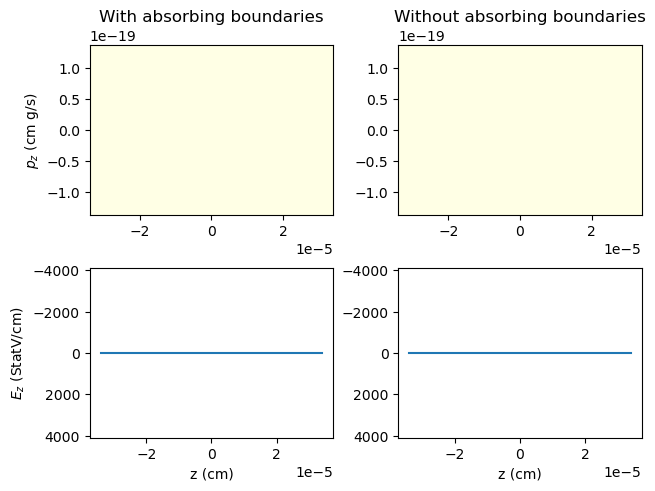

In [177]:
# initialize plot
fig, ax = plt.subplots(2, 2, constrained_layout=True)

# with absorbing boundaries
x_axis = np.linspace(xmin, xmax, nx)
Ez_plot = ax[1,0].plot(z_axis,field_dd[0,:])[0]
ax[1,0].set_ylim(-field_amplitude, field_amplitude)
zpz_plot = ax[0,0].imshow(particle_dd / (3/pmax) / (zmax - zmin) / (ymax - ymin),  #!!!!!
             extent=[xmin, xmax,pmin, pmax], 
             aspect='auto', origin='lower', 
             cmap='YlOrBr',vmin=0, vmax=1,
             interpolation = 'none')

# without absorbing boundaries
Ez_plot_we = ax[1,1].plot(x_axis[:],field_dd_without_ext[0,:])[0]
ax[1,1].set_ylim(-field_amplitude, field_amplitude)
zpz_plot_we = ax[0,1].imshow(particle_dd_without_ext / (3/pmax) / (zmax - zmin) / (ymax - ymin), 
             extent=[xmin, xmax,pmin, pmax], 
             aspect='auto', origin='lower', 
             cmap='YlOrBr',vmin=0, vmax=1,
             interpolation = 'none')

# set titles
ax[0,0].set_title('With absorbing boundaries')
ax[0,1].set_title('Without absorbing boundaries')
ax[1,0].set_xlabel('z (cm)')
ax[1,1].set_xlabel('z (cm)')
ax[0,0].set_ylabel('$p_z$ (cm g/s)')
ax[1,0].set_ylabel('$E_z$ (StatV/cm)')

In [178]:
# ===============================SIMULATION======================================
save_gif = False # set to False to show with scrollbar

import numpy as np
from matplotlib import animation
from IPython.display import HTML, display, clear_output, Image


simulation_steps = int(8 * plasma_period / timestep)
frames = simulation_steps // 8 # number of frames to show in the animation
counter = 0
def animate(i):
    data_int[0] = i # updating data int so the handler gets the right iteration number
    sim.advance(time_step=timestep, number_of_iterations=8,use_omp=True)
    sim_without_ext.advance(time_step=timestep, number_of_iterations=8,use_omp=True)

    
    sim.field_loop(handler=field_callback.address, 
                   data_double=pipic.addressof(field_dd),
                   use_omp=False)
    
    particle_dd.fill(0)
    sim.particle_loop(name='particle_name', 
                      handler=particle_callback.address, 
                      data_double=pipic.addressof(particle_dd))
    Ez_plot.set_ydata(field_dd)
    zpz_plot.set_data(particle_dd / (3/pmax) / (xmax - xmin) / (ymax - ymin))

    
    sim_without_ext.field_loop(handler=field_callback.address, 
                               data_double=pipic.addressof(field_dd),
                               use_omp=True)
    particle_dd.fill(0)
    sim_without_ext.particle_loop(name='particle_name', 
                                  handler=particle_callback.address, 
                                  data_double=pipic.addressof(particle_dd))
    Ez_plot_we.set_ydata(field_dd)
    zpz_plot_we.set_data(particle_dd / (3/pmax) / (xmax - xmin) / (ymax - ymin))

    global counter
    clear_output()
    if counter <= frames:
        display(HTML('<pre> Progress: ' + "{:.2f}".format(100*counter/frames) + '%</pre>'), display_id = True)
    counter += 1
    return 

ani = animation.FuncAnimation(fig, animate, frames=frames, interval = 40)

if save_gif == False:
    html = HTML(ani.to_jshtml())
    display(html)
    plt.close()
else:
    writer = animation.PillowWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('output_basic_example.gif', writer=writer)

In [60]:
# Delete files used for compilation of extension
!rm -rf pybind11
!rm -r CMakeFiles
!rm primitives.h interfaces.h services.h CMakeLists.txt Makefile cmake_install.cmake pipic_log.txt CMakeCache.txt pipic_performance.txt